<a href="https://colab.research.google.com/github/SewoongPark/SeSac_study_repo/blob/main/Multi_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

금요일까지 제출
* 멀티레이블 작업
* 오토인코더(텐서)

금요일:
* 1) 오토인코더 등 주제잡고 pytorch로 작업, Tensor로 작업한 내용 Torch로 변환
* 2) Tensorhub 또는 hugging-face또는 교재 gpt 모델

In [2]:
%pwd

'/content'

In [3]:
%cd ./drive/MyDrive/Task_Multilabel

/content/drive/MyDrive/Task_Multilabel


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/MyDrive/Task_Multilabel/archive (2).zip"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import pandas as pd
DATA_PATH = "./"
train_df = pd.read_csv(DATA_PATH + '/train.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')
val_df = pd.read_csv(DATA_PATH + '/val.csv')

print(train_df.head())

   Unnamed: 0                                              image  black  blue  \
0           0  ./clothes_dataset\blue_shorts\256d854b55ac32ea...    0.0   1.0   
1           1  ./clothes_dataset\red_pants\584f778aece14f07c2...    0.0   0.0   
2           2  ./clothes_dataset\green_pants\ec543ca241cefb2b...    0.0   0.0   
3           3  ./clothes_dataset\brown_shorts\c8db9e0f7010592...    0.0   0.0   
4           4  ./clothes_dataset\white_dress\551373c80717c5b0...    0.0   0.0   

   brown  green  red  white  dress  shirt  pants  shorts  shoes  
0    0.0    0.0  0.0    0.0    0.0    0.0    0.0     1.0    0.0  
1    0.0    0.0  1.0    0.0    0.0    0.0    1.0     0.0    0.0  
2    0.0    1.0  0.0    0.0    0.0    0.0    1.0     0.0    0.0  
3    1.0    0.0  0.0    0.0    0.0    0.0    0.0     1.0    0.0  
4    0.0    0.0  0.0    1.0    1.0    0.0    0.0     0.0    0.0  


In [ ]:
type(train_df.columns[2:])

pandas.core.indexes.base.Index

### 2. 이미지 제너레이터 정의 및 모델 구상하기
> 이미지 제너레이터 정의

In [22]:
from keras.preprocessing.image import ImageDataGenerator # Keras에서 이미지 데이터를 처리하기 위한 ImageDataGenerator 모듈을 호출합니다.

train_datagen = ImageDataGenerator(rescale=1. / 255) # 학습 데이터용 이미지 데이터 생성기를 정의하고 이미지의 픽셀을 255로 나누어서 0에서 1사이의 값을 가지도록 정규화해줍니다.
val_datagen = ImageDataGenerator(rescale=1. / 255)

def get_steps(num_samples, batch_size): # 모델의 훈련시에 사용할 batch size를 가변적으로 정의하기 위한 함수
    if (num_samples % batch_size) > 0: # 샘플 수를 batch size로 나눈 크기가 0보다 크다면
        return (num_samples // batch_size) + 1 # 샘플 수를 batch size로 나눈 몫에 1을 더한 값을 반환합니다.
    else:
        return num_samples // batch_size # 그렇지 않다면 batch size로 나눈 몫을 반환합니다. 이 경우 나머지가 0이므로 추가적인 batch는 필요하지 않습니다.

모델 구축하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 합니다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
#  # in: (112, 112, 3) w: flatten 층이므로 없음 out: (37632, )
# model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
#  # in: (37632, ) w: (37632, 128) out: (128,)
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
#  # in: (128, ) w: (128, 64) out: (64, )
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망
    # in: (64, ) w: (64, 11) out: (11, )
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# 각 레이어의 input, weight, output의 shape 출력
for layer in model.layers:
    print("레이어 이름:", layer.name)
    print("입력 모양:", layer.input_shape)
    print("가중치 모양:", layer.get_weights()[0].shape if layer.get_weights() else None)
    print("출력 모양:", layer.output_shape)
    print()

레이어 이름: flatten
입력 모양: (None, 112, 112, 3)
가중치 모양: None
출력 모양: (None, 37632)

레이어 이름: dense
입력 모양: (None, 37632)
가중치 모양: (37632, 64)
출력 모양: (None, 64)

레이어 이름: dense_1
입력 모양: (None, 64)
가중치 모양: (64, 11)
출력 모양: (None, 11)



SeparableConv2D, MaxPooling2D, l1, l2 규제 적용해보기

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, SeparableConv2D, MaxPooling2D
from tensorflow.keras import regularizers

model = Sequential()
model.add(SeparableConv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(SeparableConv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(SeparableConv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(11, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Printing the shapes of input, weights, and output for each layer
for layer in model.layers:
    print("Layer Name:", layer.name)
    print("Input Shape:", layer.input_shape)
    print("Output Shape:", layer.output_shape)
    print()


Layer Name: separable_conv2d
Input Shape: (None, 112, 112, 3)
Output Shape: (None, 110, 110, 32)

Layer Name: max_pooling2d
Input Shape: (None, 110, 110, 32)
Output Shape: (None, 55, 55, 32)

Layer Name: separable_conv2d_1
Input Shape: (None, 55, 55, 32)
Output Shape: (None, 53, 53, 64)

Layer Name: max_pooling2d_1
Input Shape: (None, 53, 53, 64)
Output Shape: (None, 26, 26, 64)

Layer Name: separable_conv2d_2
Input Shape: (None, 26, 26, 64)
Output Shape: (None, 24, 24, 128)

Layer Name: max_pooling2d_2
Input Shape: (None, 24, 24, 128)
Output Shape: (None, 12, 12, 128)

Layer Name: flatten_5
Input Shape: (None, 12, 12, 128)
Output Shape: (None, 18432)

Layer Name: dense_8
Input Shape: (None, 18432)
Output Shape: (None, 128)

Layer Name: dropout_1
Input Shape: (None, 128)
Output Shape: (None, 128)

Layer Name: dense_9
Input Shape: (None, 128)
Output Shape: (None, 64)

Layer Name: dense_10
Input Shape: (None, 64)
Output Shape: (None, 11)



In [ ]:
%pwd

'/content/drive/MyDrive/Task_Multilabel'

**역 슬래시 기호를 "/"로 변경**

In [8]:
train_df['image'][0] # '\'기호를 인식하지 못하여 이미지가 저장된 경로에 접근하지 못하는 문제 발생

'./clothes_dataset\\blue_shorts\\256d854b55ac32ea4d0d6398dffccc4d8909a388.jpg'

In [9]:
train_df['image'] = train_df['image'].apply(lambda x: x.replace('/', '\\'))
train_df.head() # lambda 함수를 사용하여 dataframe 내의 역슬래시 기호를 '/'로 변환하였습니다.

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,.\clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,.\clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,.\clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,.\clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,.\clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [17]:
test_df['image'].head()

0    ./clothes_dataset\blue_shorts\1ec871cdfe41ff20...
1    ./clothes_dataset\black_pants\0f8eb4509cea01f9...
2    ./clothes_dataset\white_shoes\1d70ebaec12e09f3...
3    ./clothes_dataset\green_shoes\a4e155f7249a591e...
4    ./clothes_dataset\blue_shirt\2edd17185a4f1b8d9...
Name: image, dtype: object

In [19]:
val_df['image'] = train_df['image'].apply(lambda x: x.replace('\\', '/'))
test_df['image'] = test_df['image'].apply(lambda x: x.replace('\\', '/'))

val_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset/blue_shorts/256d854b55ac32ea...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,./clothes_dataset/red_pants/584f778aece14f07c2...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset/green_pants/ec543ca241cefb2b...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,./clothes_dataset/brown_shorts/c8db9e0f7010592...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,./clothes_dataset/white_dress/551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_df.columns[2:] # target data를 위해 train_dataframe의 columns를 list로 변환하였습니다.

Index(['black', 'blue', 'brown', 'green', 'red', 'white', 'dress', 'shirt',
       'pants', 'shorts', 'shoes'],
      dtype='object')

In [ ]:
# Make Generator
batch_size = 8
train_generator = train_datagen.flow_from_dataframe( # 데이터프레임에서 이미지 데이터를 가져오는 제너레이터를 생성합니다.
    dataframe=train_df, # 이미지 데이터를 포함하고 있는 데이터프레임을 정의합니다.
    directory='./archive', # 이미지 파일을 불러올 경로를 정의합니다.
    x_col = 'image', # 이미지 파일의 경로(train_df의 image column에 적힌 이미지 경로)
    y_col = list(train_df.columns[2:]), # 이미지와 클래스 분류를 수행하기 위한 열 목록을 지정합니다.
    target_size = (112, 112), # 입력 이미지의 크기를 지정합니다. (224, 224)로 테스트 해봤는데 학습 속도가 너무 오래 걸리는 문제를 확인했습니다.
    color_mode='rgb', # 이미지의 색상 모드를 R,G,B 3개의 채널로 지정합니다.
    class_mode='raw', # 클래스 모드를 지정합니다. 이 경우에는 다중 클래스 분류 문제를 다루고 있으므로 'other'로 설정합니다.
    batch_size=batch_size, # batch의 크기를 지정합니다. 정밀한 학습을 위해 8로 지정했습니다.
    seed=42 # 난수 생성 알고리즘의 초기값을 지정합니다. 학습 과정을 재현하기 위해 데이터를 섞지 않고 seed 값을 고정합니다.
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./archive',
    x_col = 'image',
    y_col = list(val_df.columns[2:]),
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

len(train_generator)

Found 5578 validated image filenames.
Found 2391 validated image filenames.


698

In [ ]:
history = model.fit(train_generator,
         steps_per_epoch=get_steps(len(train_df), batch_size), # 전체 데이터의 길이와 batch 사이즈의 크기를 비교하여 epoch 횟수를 할당합니다.
         validation_data = val_generator, # 검증 데이터를 사용하여 학습 데이터에 대한 과적합을 방지하고, 모델의 성능을 모니터링하며 하이퍼퍼라미터를 조정합니다.
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 40)

Epoch 1/40
698/698 [==============================] - 16s 22ms/step - loss: 0.5313 - acc: 0.2193 - val_loss: 0.5779 - val_acc: 0.1117
Epoch 2/40
698/698 [==============================] - 15s 22ms/step - loss: 0.4036 - acc: 0.1045 - val_loss: 0.5947 - val_acc: 0.0318
Epoch 3/40
698/698 [==============================] - 15s 22ms/step - loss: 0.3723 - acc: 0.0762 - val_loss: 0.7337 - val_acc: 0.0452
Epoch 4/40
698/698 [==============================] - 15s 22ms/step - loss: 0.3538 - acc: 0.1067 - val_loss: 0.7489 - val_acc: 0.0335
Epoch 5/40
698/698 [==============================] - 16s 22ms/step - loss: 0.3437 - acc: 0.1804 - val_loss: 0.7208 - val_acc: 0.0548
Epoch 6/40
698/698 [==============================] - 16s 22ms/step - loss: 0.3329 - acc: 0.2297 - val_loss: 0.7972 - val_acc: 0.1138
Epoch 7/40
698/698 [==============================] - 15s 22ms/step - loss: 0.3300 - acc: 0.2608 - val_loss: 0.8175 - val_acc: 0.1125
Epoch 8/40
698/698 [==============================] - 15s 22ms

### 레이어의 수를 줄였더니(Dropout말고 물리적으로) 성능이 미세하게 향상되는 것 확인

In [ ]:
history = model.fit(train_generator, # 레이어 1개
         steps_per_epoch=get_steps(len(train_df), batch_size), # 전체 데이터의 길이와 batch 사이즈의 크기를 비교하여 epoch 횟수를 할당합니다.
         validation_data = val_generator, # 검증 데이터를 사용하여 학습 데이터에 대한 과적합을 방지하고, 모델의 성능을 모니터링하며 하이퍼퍼라미터를 조정합니다.
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 20)

Epoch 1/20
698/698 [==============================] - 44s 62ms/step - loss: 0.5131 - acc: 0.2551 - val_loss: 0.6945 - val_acc: 0.0519
Epoch 2/20
698/698 [==============================] - 15s 21ms/step - loss: 0.3634 - acc: 0.3530 - val_loss: 0.8460 - val_acc: 0.1221
Epoch 3/20
698/698 [==============================] - 15s 21ms/step - loss: 0.3088 - acc: 0.4953 - val_loss: 0.9479 - val_acc: 0.1476
Epoch 4/20
698/698 [==============================] - 15s 22ms/step - loss: 0.2774 - acc: 0.5746 - val_loss: 1.0165 - val_acc: 0.1380
Epoch 5/20
698/698 [==============================] - 15s 22ms/step - loss: 0.2666 - acc: 0.5934 - val_loss: 1.0273 - val_acc: 0.1372
Epoch 6/20
698/698 [==============================] - 15s 22ms/step - loss: 0.2705 - acc: 0.5895 - val_loss: 1.0563 - val_acc: 0.1380
Epoch 7/20
698/698 [==============================] - 15s 22ms/step - loss: 0.2559 - acc: 0.5961 - val_loss: 1.0750 - val_acc: 0.1489
Epoch 8/20
698/698 [==============================] - 15s 21ms

### 모델 성능 그래프

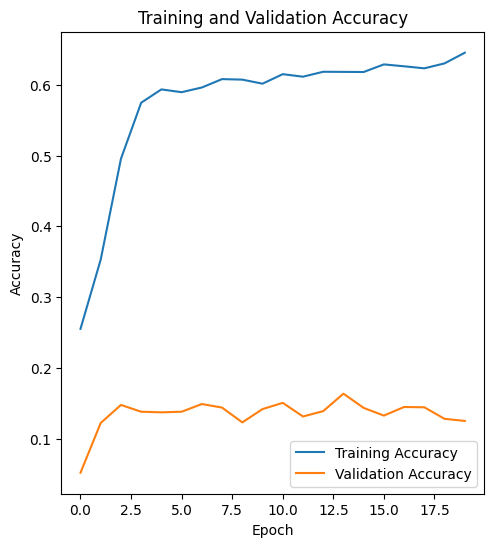

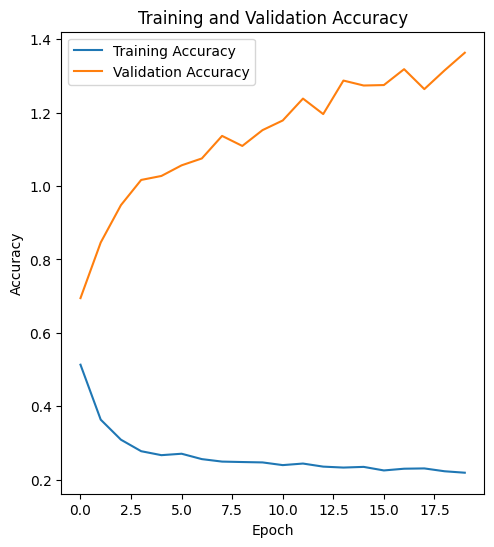

In [ ]:
import matplotlib.pyplot as plt
hist = history.history
# 훈련 및 검증 정확도 데이터 추출
train_acc, train_loss = hist['acc'], hist['loss']
val_acc, val_loss = hist['val_acc'], hist['val_loss']

# 정확도 그래프 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()  # 범례 표시
plt.show()

# 정확도 그래프 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()  # 범례 표시
plt.show()

In [ ]:
# 6. 모델 저장하기
import os
save_path = os.path.join('model', 'img_generator_light_model.h5')
model.save(save_path)

In [ ]:
test_df['image'].tolist()

In [13]:
%pwd

'/content/drive/MyDrive/Task_Multilabel'

In [7]:
from keras.models import load_model

# 모델 파일 경로
model_path = '/content/drive/MyDrive/Task_Multilabel/img_generator_model.h5'

# 모델 로드
model = load_model(model_path)

### 클래스화

1/1 [==============================] - 0s 41ms/step


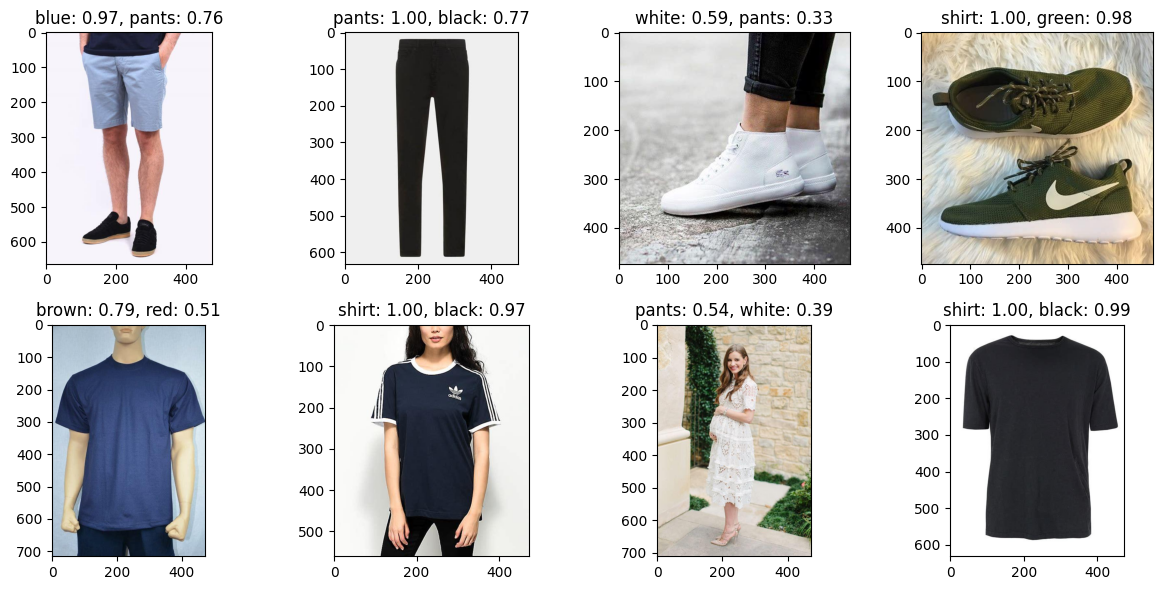

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class ImagePredictor: # 이미지 예측기 클래스를 정의합니다.
    def __init__(self, model, test_df): # 이미지 예측기 클래스의 생성자를 지정합니다. model과 test_dataframe을 인수로 받습니다.
        self.model = model # 인스턴스 변수 model을 할당합니다.
        self.test_df = test_df # 인스턴스 변수에 test_dataframe을 할당합니다.

    def predict_and_visualize(self, num_images=8): # 이미지를 예측하고 시각화하는 메서드를 정의합니다.
        preds = [] # 예측 결과를 저장할 빈 리스트를 생성합니다.
        test_image_paths = self.test_df['image'].tolist() # test_dataframe에서 이미지 경로를 가져와 iterable한 리스트로 변환합니다.

        plt.figure(figsize=(12, 6)) # 이미지를 시각화하기 위한 plot을 생성합니다.

        for i, img_path in enumerate(test_image_paths[:num_images]): # 지정한 num_images 수만큼의 이미지를 보여줍니다.
            image = cv2.imread(img_path) # OPENCV 라이브러리를 사용하여 이미지를 읽어옵니다.
            image = cv2.resize(image, (112, 112)) # 입력 데이터 사이즈를 변환합니다. 학습한 모델의 입력 사이즈와 동일하게 설정합니다.
            image = image.astype(np.float32) / 255.0 # 이미지의 픽셀 값을 float 타입으로 변환합니다 (pixel.)
            image = np.expand_dims(image, axis=0) # array 연산을 하기 위해 이미지를 numpy array로 변환하고, 축을 할당하여 batch의 차원을 만듭니다.
                                                    #  이는 이미지를 하나의 배치로 간주함을 의미합니다.

            pred = self.model.predict(image) # 모델을 사용하여 이미지를 예측합니다.
            preds.append(pred)

            classes = list(self.test_df.columns[2:]) # 클래스 라벨을 가져와 리스트로 변환합니다.
            top_classes = np.argsort(pred[0])[::-1][:2] # 가장 높은 확률을 갖는 상위 2개 클래스의 인덱스를 가져옵니다.
            top_probs = pred[0][top_classes]  # 예측 확률 중 상위 클래스에 해당하는 확률을 가져옵니다.
            top_class_names = [classes[idx] for idx in top_classes] # 상위 클래스와 대응하는 클래스 값을 가져옵니다.

            plt.subplot(2, 4, i + 1) # 이미지를 시각화할 서브플롯을 생성합니다. 이미지가 8개 이므로 2행 4열
            plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)) # openCV의 채널 구조인 BGR을 RGB로 변환하여 plot에 출력합니다.
            plt.title(f'{top_class_names[0]}: {top_probs[0]:.2f}, {top_class_names[1]}: {top_probs[1]:.2f}') # 서브 플롯의 제목을 설정합니다. 예측 결과와 확률을 표시합니다.

        plt.tight_layout()
        plt.show()

# ImagePredictor 객체 생성
predictor = ImagePredictor(model, test_df)
# 이미지 예측 및 시각화
predictor.predict_and_visualize()
